# Analysis, detection & mitigation of felonious wallet accounts over the Ethereum Blockchain network using Machine Learning techniques

| BITS ID No. | Name of Student    | Email                          | Mobile     |
| ------------| ------------------ | ------------------------------ | ---------- |
| 2019HC04178 | Anjali Sunder Naik | sundernaik.anjali@in.bosch.com | 8147757114 |

# Category: Externally Owned Account

# 1. Problem Statement

As of 2021, a survey from Coin Market Cap indicates that there are nearly over 6,000 digital coins in the market, a severe increase from just a handful since 2013. However, a large portion of these cryptocurrencies might not be that significant. The total market cap of all the crypto assets, including stable coins and tokens has shown a significant rise from year 2020 and has hit 2.4 trillion. Cryptocurrencies has vast potential of revolutionizing and transforming compliance-free peer-to-peer transactions. However, an end user must overcome certain challenges related to privacy, security, and control. As the transactions are recorded in a publicly distributed ledger known as blockchain, hackers have a large attack surface to gain access to critical and sensitive data. In the rapidly growing crypto currency space, the technological advent of cryptocurrencies and their respective benefits has been veiled with several illicit financing activities operating over the network such as ransomware, terrorist financing, hacking, data manipulation during transaction process, phishing, fraud, money laundering, bribery etc. Chainalysis, a firm that tracks every crypto currency transaction and serves as an advisor to an array of government authorities has published a report that shows that the amount of cryptocurrency spent on dark net markets rose 60% to reach a new high of $1.15billion from July 2020 to June 2021

# 2. Data Collection
1. What kind of problem are we trying to solve?
    - Fraud Detection, Categorical Analysis
2. What data sources already exist?
    - Ethereum Foundation Blacklist, Etherscan, Harvard Verse 
3. What privacy concerns are there?
    - NA
4. Is the data public?
    - Yes
5. Where should we store the files?
    - Local Store
6. What is the type of data collected?
    - Structured

# 3. Data Preparation

We collect the raw list of valid and invalid (blacklisted) ethereum accounts from ether scan, which are a combination of both EOA & Smart Contracts

In [1]:
# imports

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from IPython.display import display
from sklearn.feature_selection import mutual_info_classif

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report


from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn import model_selection
from sklearn.utils import class_weight
import xgboost as xgb

import pickle

In [2]:
# constants

invalid_data_path = '../data/invalid/invalid.csv'
valid_data_path = '../data/valid/valid.csv'

eoa_features_path_valid = '../data/valid/features_valid/part-r-00000'
eoa_feat_valid = '../data/valid/features_valid/part-c-00000.csv'

eoa_features_path_invalid = '../data/invalid/features_invalid/part-r-00000'
eoa_feat_invalid = '../data/invalid/features_invalid/part-c-00000.csv'


eoa_feat_valid_file_path = './exec-results/eoa/eoa_feat_valid.csv'
eoa_feat_invalid_file_path = './exec-results/eoa/eoa_feat_invalid.csv'

## 3.1 Data Visualization

### 3.1.1 Felonious Accounts

In [3]:
df = pd.read_csv(invalid_data_path)

print("Total number of felonious accounts in the dataset: ",df.shape[0])

df.head()

Total number of felonious accounts in the dataset:  8476


,Address,Name Tag,Balance,Txn Count,label
0,0x9f26ae5cd245bfeeb5926d61497550f79d9c6c1c,Akropolis Hacker 1,0 Ether,29.0,phish-hack
1,0xbceaa0040764009fdcff407e82ad1f06465fd2c4,Bancor Hacker,0 Ether,3.0,phish-hack
2,0x03b70dc31abf9cf6c1cf80bfeeb322e8d3dbb4ca,Browser Extension Hack,0 Ether,64.0,phish-hack
3,0x4639cd8cd52ec1cf2e496a606ce28d8afb1c792f,CBDAO: BREE Token,0 Ether,6897.0,phish-hack
4,0xeda5066780de29d00dfb54581a707ef6f52d8113,ChainSwap Hacker,0.11961143 Ether,771.0,phish-hack


<AxesSubplot:title={'center':'Felonious Ethereum Accounts data'}>

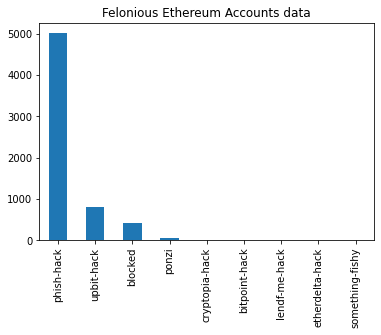

In [4]:
plt.title("Felonious Ethereum Accounts data")
df['label'].value_counts().plot(kind='bar')

### 3.1.2 Non-Felonious Accounts

In [5]:
df = pd.read_csv(valid_data_path)

print("Total number of non-felonious accounts in the dataset: ",df.shape[0])

df.head()

Total number of non-felonious accounts in the dataset:  8843


,Address
0,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8
1,0x0002b44ddb1476db43c868bd494422ee4c136fed
2,0x001f99982965a3792077893ecadc7be0c61d613c
3,0x0045eb75acf6e1cb1d9ec41e352a879e2cd50b35
4,0x00472c1e4275230354dbe5007a5976053f12610a


In [6]:
df = pd.read_csv(eoa_features_path_valid)

print("Total number of non-felonious EOA in the dataset: ",df.shape[0])

Total number of non-felonious EOA in the dataset:  2082


In [7]:
with open(eoa_features_path_valid) as fin, open(eoa_feat_valid, 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ','))
        
df = pd.read_csv(eoa_feat_valid)

eoa_features_header = [
    'address',
    'f1_total_transactions_sent',
    'f2_total_transactions_received',
    'f3_value_out',
    'f4_value_in',
    'f5_value_difference',
    'f6_number_of_distinct_address_contacted',
    'f7_total_transactions_sent_received',
    'f8_total_transactions_sent_to_unique_address',
    'f9_total_transactions_received_from_unique_address',
    'f10_first_transaction_time',
    'f11_last_transaction_time',
    'f12_transction_active_duration',
    'f13_last_txn_bit',
    'f14_last_transaction_value',
    'f15_average_incoming_ether',
    'f16_average_outgoing_ether',
    'f17_average_percentage_gas_incoming',
    'f18_average_percentage_gas_outgoing',
    'f19_outgoing_gas_price',
    'f20_incoming_gas_price',
    'f21_average_incoming_gas_price',
    'f22_average_outgoing_gas_price',
    'f23_total_failed_transactions_incoming',
    'f24_total_failed_transactions_outgoing',
    'f25_total_failed_transactions',
    'f26_total_success_transactions_incoming',
    'f27_total_success_transactions_outgoing',
    'f28_total_success_transactions',
    'f29_gas_used_incoming_transaction',
    'f30_gas_used_outgoing_transaction',
    'f31_percentage_transaction_sent',
    'f32_percentage_transaction_received',
    'f33_standard_deviation_ether_incoming',
    'f34_standard_deviation_ether_outgoing',
    'f35_standard_deviation_gas_price_incoming',
    'f36_standard_deviation_gas_price_outgoing',
    'f37_first_transaction_bit',
    'f38_first_transaction_value',
    'f39_mean_in_time',
    'f40_mean_out_time',
    'f41_mean_time',
    'f42_transaction_fee_spent_incoming',
    'f43_transaction_fee_spent_outgoing',
    'f44_transaction_fee_spent','class']
  

# converting data frame to csv
df.to_csv(eoa_feat_valid_file_path, header=eoa_features_header, index=False)
  
# display modified csv file
df = pd.read_csv(eoa_feat_valid_file_path)
df.head()
print("Total number of non-felonious EOA in the dataset: ",df.shape[0])

Total number of non-felonious EOA in the dataset:  2082


In [8]:
with open(eoa_features_path_invalid) as fin, open(eoa_feat_invalid, 'w') as fout:
    for line in fin:
        fout.write(line.replace('\t', ','))
        
df1 = pd.read_csv(eoa_feat_invalid)
  
# converting data frame to csv
df1.to_csv(eoa_feat_invalid_file_path, header=eoa_features_header, index=False)
  
# display modified csv file
df1 = pd.read_csv(eoa_feat_invalid_file_path)

print("Total number of invalid EOA in the dataset: ",df1.shape[0])
df1.head()

Total number of invalid EOA in the dataset:  4949


,address,f1_total_transactions_sent,f2_total_transactions_received,f3_value_out,f4_value_in,f5_value_difference,f6_number_of_distinct_address_contacted,f7_total_transactions_sent_received,f8_total_transactions_sent_to_unique_address,f9_total_transactions_received_from_unique_address,...,f36_standard_deviation_gas_price_outgoing,f37_first_transaction_bit,f38_first_transaction_value,f39_mean_in_time,f40_mean_out_time,f41_mean_time,f42_transaction_fee_spent_incoming,f43_transaction_fee_spent_outgoing,f44_transaction_fee_spent,class
0,0x000000000532b45f47779fce440748893b257865,3,20,117129473448396783579,117132024948396783579,2551500000000000,23,23,3,20,...,1.363964e+10,0,10000000000000000,2762.315789,187.500000,4018.045455,647000,63000,710000,1
1,0x00000000072d54638c2c2a3da3f715360269eea1,23,30,215965532670900878881,215193909626600024725,771623044300854156,44,53,17,28,...,5.911801e+10,0,208090008807822760222,9731.448276,7883.136364,5601.750000,816128,2111665,2927793,1
2,0x0000000009324b6434d7766af41908e4c49ee1d7,6,9,164209042700051608248,164214901700051608248,5859000000000000,12,15,3,9,...,2.309416e+10,0,5007000000000000000,5500.250000,13080.000000,4951.214286,198000,126000,324000,1
3,0x0000000086c5d614bec59dfd2c9b88f7cb57f23c,1,5,60502304943000000000,50502913943000000000,9999391000000000000,6,6,1,5,...,1.080766e+10,0,5000000000000000000,2428.250000,0.000000,16253.600000,105000,21000,126000,1
4,0x00000000bf02300fd6251627aa3db8933a0eee83,4,20,101761013504336217918,81766423504336217918,19994590000000000000,18,24,2,17,...,1.956559e+10,0,28632134336217918,5339.368421,30782.333333,5780.695652,1166050,84000,1250050,1


In [9]:
# let us merge the EOA dataset with felonious and non-felonious data

df_cd = pd.merge(df, df1, how='outer')
df_cd

,address,f1_total_transactions_sent,f2_total_transactions_received,f3_value_out,f4_value_in,f5_value_difference,f6_number_of_distinct_address_contacted,f7_total_transactions_sent_received,f8_total_transactions_sent_to_unique_address,f9_total_transactions_received_from_unique_address,...,f36_standard_deviation_gas_price_outgoing,f37_first_transaction_bit,f38_first_transaction_value,f39_mean_in_time,f40_mean_out_time,f41_mean_time,f42_transaction_fee_spent_incoming,f43_transaction_fee_spent_outgoing,f44_transaction_fee_spent,class
0,0x0002b44ddb1476db43c868bd494422ee4c136fed,229,7,3214922525794464472,3111926746271008368,102995779523456104,42,236,39,6,...,1.418579e+10,0,2613268790000000000,2.505182e+07,5.849192e+05,5.730382e+05,459333,21481054,21898387,0
1,0x0012f247c9f980eea0a9ad06893bfd95c3145794,8,3,149077000000000000000,50100000000000000000,98977000000000000000,5,11,4,2,...,2.360005e+10,0,100000000000000000,3.002405e+05,1.479854e+05,1.834362e+05,205266,2715000,2920266,0
2,0x0016338abcb6bfa6d355adc207c5d2d42acb5e42,8,246,831799000000000000000,831803047714000000000,4047714000000000,7,254,3,4,...,4.268246e+09,0,9144644537000000000,8.782686e+04,2.893156e+06,9.153249e+04,196200000,168000,196368000,0
3,0x001866ae5b3de6caa5a51543fd9fb64f524f5478,2656,1177,46128193992720000000000,47235911241260834150079,1107717248540834150079,1997,3833,897,1104,...,1.174572e+10,0,74711997997851028000,1.185374e+05,2.524524e+04,3.688519e+04,25765104,136209878,161953982,0
4,0x001f99982965a3792077893ecadc7be0c61d613c,2,2,100998973781596769000,101000000000000000000,1026218403231000,4,4,2,2,...,1.226698e+10,0,44048882182069392381,1.330000e+02,1.965400e+04,4.433333e+01,42000,111000,153000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7026,0xff72982d880dc180ce738ca2d40c4c849365a443,1,1,19999916000000000000,20000000000000000000,84000000000000,2,2,1,1,...,2.000000e+09,0,20000000000000000000,0.000000e+00,0.000000e+00,1.001770e+05,21000,21000,42000,1
7027,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,67,43,61785994932000000000,53070251570000000000,8715743362000000000,71,110,44,31,...,1.173421e+10,0,3159238240000000000,3.598522e+05,2.356608e+05,1.440010e+05,1490200,6244000,7734200,1
7028,0xffb19ea3dbb08615945c3e6f380fa77c1819ebe8,3,2,59072760000000000,79619500000000000,20546740000000000,3,5,2,1,...,1.522094e+11,0,32219500000000000,1.534000e+05,2.918406e+06,1.473914e+06,42000,144608,186608,1
7029,0xffcc89233015b37a136e95525905fb4fd1256777,3,1,300000000000000000000,300000000000000000000,0,2,4,1,1,...,2.465132e+10,0,300000000000000000000,0.000000e+00,1.092420e+05,7.391367e+04,21000,3600000,3621000,1


In [10]:
df = df_cd
df.drop(['address',], inplace=True, axis=1)
print(df.isnull().values.any())
nan_rows = df[df.isnull().T.any()]
nan_rows

True


,f1_total_transactions_sent,f2_total_transactions_received,f3_value_out,f4_value_in,f5_value_difference,f6_number_of_distinct_address_contacted,f7_total_transactions_sent_received,f8_total_transactions_sent_to_unique_address,f9_total_transactions_received_from_unique_address,f10_first_transaction_time,...,f36_standard_deviation_gas_price_outgoing,f37_first_transaction_bit,f38_first_transaction_value,f39_mean_in_time,f40_mean_out_time,f41_mean_time,f42_transaction_fee_spent_incoming,f43_transaction_fee_spent_outgoing,f44_transaction_fee_spent,class
234,0,83,0,96328097224940424134,96328097224940424134,1,83,0,1,1478383744,...,0.000000e+00,0,1000216411101056100,6.465170e+05,0.0,6.465170e+05,5750000,0,5750000,0
315,0,3,0,695681442420105198,695681442420105198,3,3,0,3,1635930370,...,0.000000e+00,0,40681442420105198,1.097686e+06,0.0,7.317907e+05,249128,0,680328,0
454,0,15,0,50000000000000000,50000000000000000,9,15,0,9,1516402194,...,0.000000e+00,0,10000000000000000,8.716119e+05,0.0,8.716119e+05,2243004,0,2243004,0
481,0,26,0,177328307659680000000000,177328307659680000000000,2,26,0,2,1610621671,...,0.000000e+00,0,177328307659680000000000,1.170398e+06,0.0,1.170398e+06,662500,0,662500,0
546,0,10000,0,232783072047021898078977,232783072047021898078977,2371,10000,0,2371,1545098099,...,0.000000e+00,0,50000000000000000,4.275720e+02,0.0,4.275720e+02,1052613299,0,1052613299,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6673,0,24,0,24887509920000000000,24887509920000000000,24,24,0,24,1529507369,...,0.000000e+00,0,500000000000000000,4.397687e+04,0.0,4.397687e+04,3544000,0,3544000,1
6769,2,0,296145000000000000,0,296145000000000000,1,2,1,0,1622694325,...,1.500000e+09,1,18242432544443810,0.000000e+00,161.0,1.610000e+02,0,42000,42000,1
6777,0,2,0,2042982830000000000,2042982830000000000,2,2,0,2,1612183537,...,0.000000e+00,0,837930000000000000,2.232000e+03,0.0,2.232000e+03,55505,0,55505,1
6903,0,2,0,10000000000000000000,10000000000000000000,2,2,0,2,1575443844,...,0.000000e+00,0,10000000000000000000,2.184700e+04,0.0,2.184700e+04,81000,0,81000,1


In [11]:
df.describe()

,f1_total_transactions_sent,f2_total_transactions_received,f6_number_of_distinct_address_contacted,f7_total_transactions_sent_received,f8_total_transactions_sent_to_unique_address,f9_total_transactions_received_from_unique_address,f10_first_transaction_time,f11_last_transaction_time,f12_transction_active_duration,f13_last_txn_bit,...,f35_standard_deviation_gas_price_incoming,f36_standard_deviation_gas_price_outgoing,f37_first_transaction_bit,f39_mean_in_time,f40_mean_out_time,f41_mean_time,f42_transaction_fee_spent_incoming,f43_transaction_fee_spent_outgoing,f44_transaction_fee_spent,class
count,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7031.000000,7.031000e+03,7.031000e+03,7.031000e+03,7031.000000,...,7.031000e+03,7.031000e+03,7031.000000,7.031000e+03,7.031000e+03,7.031000e+03,7.031000e+03,7.031000e+03,7.031000e+03,7031.000000
mean,203.741715,129.739297,125.096999,333.481013,62.931731,63.703883,1.537572e+09,1.550497e+09,1.292519e+07,0.898450,...,2.270976e+10,2.031925e+10,0.004551,7.378429e+05,1.273262e+06,9.565798e+05,7.882566e+06,3.327116e+07,4.117961e+07,0.703883
std,1206.668630,866.393282,776.681919,1620.152138,486.386047,513.892038,3.897605e+07,4.298667e+07,2.867638e+07,0.302077,...,4.379081e+10,4.067616e+10,0.067314,3.617559e+06,6.585189e+06,4.218243e+06,7.754492e+07,2.989459e+08,3.205681e+08,0.456576
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.438950e+09,1.446266e+09,1.000000e+00,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.200000e+04,0.000000
25%,1.000000,2.000000,3.000000,4.000000,1.000000,2.000000,1.497323e+09,1.513589e+09,1.978700e+04,1.000000,...,1.100255e+10,8.571594e+09,0.000000,3.000000e+01,0.000000e+00,3.383761e+03,4.200000e+04,2.100000e+04,1.320000e+05,0.000000
50%,3.000000,4.000000,6.000000,8.000000,2.000000,3.000000,1.528036e+09,1.539585e+09,7.702850e+05,1.000000,...,1.606238e+10,1.161078e+10,0.000000,9.680680e+03,3.585000e+03,5.221380e+04,1.470000e+05,1.050000e+05,3.100000e+05,1.000000
75%,10.000000,15.000000,17.000000,28.000000,5.000000,9.000000,1.575657e+09,1.581722e+09,9.297965e+06,1.000000,...,2.311938e+10,1.977904e+10,0.000000,1.636411e+05,3.070179e+05,3.871559e+05,6.666660e+05,3.990000e+05,1.544673e+06,1.000000
max,10000.000000,10000.000000,10000.000000,10099.000000,9960.000000,10000.000000,1.638223e+09,1.643590e+09,2.028733e+08,1.000000,...,2.345953e+12,2.036983e+12,1.000000,1.121441e+08,1.229295e+08,1.171386e+08,2.668042e+09,9.394540e+09,9.396237e+09,1.000000


In [12]:
# drop the null values
df.dropna(inplace=True)

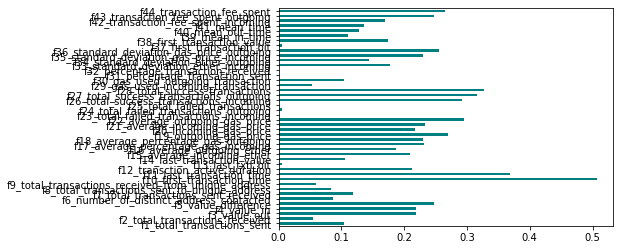

f10_first_transaction_time 0.5078283385578866
f11_last_transaction_time 0.3689468220033978
f28_total_success_transactions 0.32750239860581076
f27_total_success_transactions_outgoing 0.3166087114396814
f22_average_outgoing_gas_price 0.29469023216528467
f26_total_success_transactions_incoming 0.29200763898237847
f19_outgoing_gas_price 0.2691566134985095
f44_transaction_fee_spent 0.26463002109776035
f36_standard_deviation_gas_price_outgoing 0.25541472205622684
f5_value_difference 0.24711574539412395

The top 10 features for EOA DF are :
Index(['f10_first_transaction_time', 'f11_last_transaction_time',
       'f28_total_success_transactions',
       'f27_total_success_transactions_outgoing',
       'f22_average_outgoing_gas_price',
       'f26_total_success_transactions_incoming', 'f19_outgoing_gas_price',
       'f44_transaction_fee_spent',
       'f36_standard_deviation_gas_price_outgoing', 'f5_value_difference'],
      dtype='object')


In [13]:
# Let's convert the DataFrame object to a NumPy array to achieve faster computation. 
# Also, let's segregate the data into separate variables so that the features and the labels are separated.

array = df.values

X = array[:,0:44]
Y = array[:,44]

Y = Y.astype('int')

%matplotlib inline

importances = mutual_info_classif(X,Y)
feat_importances = pd.Series(importances, df.columns[0:len(df.columns)-1])
feat_importances.plot(kind = 'barh', color = 'teal')

plt.show()

# Show the top 10 high scored features
threshold = 10  # the number of most relevant features
high_score_features = []

for score, f_name in sorted(zip(feat_importances, df.columns), reverse=True)[:threshold]:
        print(f_name, score)
        high_score_features.append(f_name)
        
eoa_df_top_features = df[high_score_features]

print("\nThe top "+"% s" % threshold + " features for EOA DF are :")
print(eoa_df_top_features.columns)

In [14]:
col  =  eoa_df_top_features.columns
cl = col.append(pd.Index(['class']))
cl

Index(['f10_first_transaction_time', 'f11_last_transaction_time',
       'f28_total_success_transactions',
       'f27_total_success_transactions_outgoing',
       'f22_average_outgoing_gas_price',
       'f26_total_success_transactions_incoming', 'f19_outgoing_gas_price',
       'f44_transaction_fee_spent',
       'f36_standard_deviation_gas_price_outgoing', 'f5_value_difference',
       'class'],
      dtype='object')

In [15]:
evaluation_df = df[cl]
evaluation_df

,f10_first_transaction_time,f11_last_transaction_time,f28_total_success_transactions,f27_total_success_transactions_outgoing,f22_average_outgoing_gas_price,f26_total_success_transactions_incoming,f19_outgoing_gas_price,f44_transaction_fee_spent,f36_standard_deviation_gas_price_outgoing,f5_value_difference,class
0,1481991771,1640005639,160.0,157,1.261390e+10,5,2888582657988,21898387,1.418579e+10,102995779523456104,0
1,1497323119,1499157481,0.0,0,4.906100e+10,0,392487962084,2920266,2.360005e+10,98977000000000000000,0
2,1490574562,1513732281,51.0,2,2.370000e+10,49,189600000000,196368000,4.268246e+09,4047714000000000,0
3,1499222973,1640942898,140.0,108,2.195812e+10,33,58320767052129,161953982,1.174572e+10,1107717248540834150079,0
4,1496262668,1496282455,0.0,0,2.443377e+10,0,48867543011,153000,1.226698e+10,1026218403231000,0
...,...,...,...,...,...,...,...,...,...,...,...
7026,1542119761,1542219938,2.0,1,4.000000e+09,1,4000000000,42000,2.000000e+09,84000000000000,1
7027,1517953257,1533649370,104.0,61,8.120970e+09,43,544105000000,7734200,1.173421e+10,8715743362000000000,1
7028,1598806715,1604702369,5.0,3,2.190250e+11,2,657075000000,186608,1.522094e+11,20546740000000000,1
7029,1604162812,1604384553,4.0,3,4.966667e+10,1,149000000000,3621000,2.465132e+10,0,1


# 4. Training

In [16]:
dfs = []
results = []
names = []
scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
target_names = ['felonious', 'non-felonious']

## 4.2 Data Splitting
We split the dataset into 80%-20% for the training and testing of our model.

In [17]:
array = evaluation_df.values

X = array[:,0:10]
y = array[:,10]
y = Y.astype('int')

## 4.3 k-NN Classifier

In [18]:
le = LabelEncoder()
X[:,0] = le.fit_transform(X[:,0])

In [19]:
# Splitting the dataset into the Training set and Test set

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0)

In [20]:
# Feature Scaling

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [21]:
# Training the K-NN model on the Training set

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(classifier, X_train, y_train, cv=kfold, scoring=scoring)

classifier.fit(X_train, y_train)

pickle.dump(classifier, open('exec-results/eoa/models/knn.pkl','wb'))

In [22]:
# Predicting the Test set results
y_pred = classifier.predict(X_test)

In [23]:
# Making the Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
ac = accuracy_score(y_test,y_pred)
print(cm)
print(ac)
print(classification_report(y_test, y_pred, target_names=target_names))

[[384  15]
 [ 14 976]]
0.9791216702663786
               precision    recall  f1-score   support

    felonious       0.96      0.96      0.96       399
non-felonious       0.98      0.99      0.99       990

     accuracy                           0.98      1389
    macro avg       0.97      0.97      0.97      1389
 weighted avg       0.98      0.98      0.98      1389



In [24]:
# for analysis
name = 'KNN'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.4 Decision Tree Classifier

In [25]:
# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)


print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)

Training split input-  (5552, 10)
Testing split input-  (1389, 10)


In [26]:
# Defining the decision tree algorithm
dtree=DecisionTreeClassifier()

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(dtree, X_train, y_train, cv=kfold, scoring=scoring)

dtree.fit(X_train,y_train)

pickle.dump(classifier, open('exec-results/eoa/models/dt.pkl','wb'))

In [27]:
y_pred = dtree.predict([np.array(X_test[0])])
str(y_pred[0])

'1'

In [28]:
# Predicting the values of test data
y_pred = dtree.predict(X_test)
print("Classification report - \n", classification_report(y_test,y_pred))

Classification report - 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98       428
           1       0.99      0.99      0.99       961

    accuracy                           0.99      1389
   macro avg       0.99      0.99      0.99      1389
weighted avg       0.99      0.99      0.99      1389



Text(0.5, 1.0, 'Accuracy Score: 0.9877609791216703')

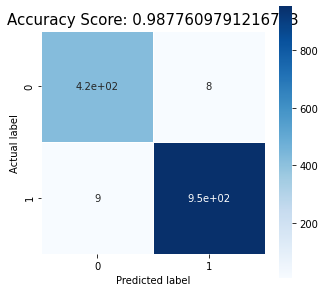

In [29]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
sns.heatmap(data=cm,linewidths=.5, annot=True,square = True,  cmap = 'Blues')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(dtree.score(X_test, y_test))
plt.title(all_sample_title, size = 15)

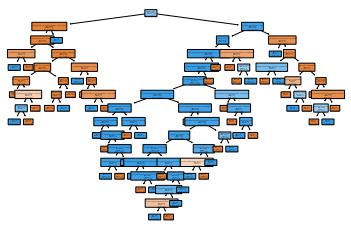

In [30]:
# Visualising the graph without the use of graphvizplt.figure(figsize = (20,20))
dec_tree = plot_tree(decision_tree=dtree, feature_names = df1.columns, 
                     class_names =["Felonious", "Non-Felonious"] , filled = True , precision = 4, rounded = True)

plt.savefig('./exec-results/eoa/analysis/decision_tree.png',dpi=300)

In [31]:
# for analysis
name = 'DT'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.5 Random Forest Classifier

In [32]:
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)

kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(clf, X_train, y_train, cv=kfold, scoring=scoring)

# Splitting the data - 80:20 ratio
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.2, random_state = 42)
print("Training split input- ", X_train.shape)
print("Testing split input- ", X_test.shape)


#Train the model using the training sets y_pred=clf.predict(X_test)
clf.fit(X_train,y_train)
pickle.dump(classifier, open('exec-results/eoa/models/rf.pkl','wb'))

y_pred=clf.predict(X_test)

Training split input-  (5552, 10)
Testing split input-  (1389, 10)


In [33]:
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",accuracy_score(y_test, y_pred))

Accuracy: 0.9935205183585313


In [34]:
# for analysis
name = 'RF'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 4.6 XGBoost Classifier

In [35]:
# Init classifier
xgb_cl = xgb.XGBClassifier(eval_metric='mlogloss', use_label_encoder =False)


kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=90210)
cv_results = model_selection.cross_validate(xgb_cl, X_train, y_train, cv=kfold, scoring=scoring)

# Fit
xgb_cl.fit(X_train, y_train)

# Store the model

pickle.dump(classifier, open('exec-results/eoa/models/xgb.pkl','wb'))

# Predict
preds = xgb_cl.predict(X_test)

# Score
accuracy_score(y_test, preds)

0.9920806335493161

In [36]:
# for analysis
name = 'XGB'
results.append(cv_results)
names.append(name)
this_df = pd.DataFrame(cv_results)
this_df['model'] = name
dfs.append(this_df)
final = pd.concat(dfs, ignore_index=True)

## 5. Analysis/Evaluation

In [37]:
bootstraps = []
for model in list(set(final.model.values)):
    model_df = final.loc[final.model == model]
    bootstrap = model_df.sample(n=30, replace=True)
    bootstraps.append(bootstrap)
        
bootstrap_df = pd.concat(bootstraps, ignore_index=True)
results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
time_metrics = ['fit_time','score_time'] # fit time metrics
## PERFORMANCE METRICS
results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
results_long_nofit = results_long_nofit.sort_values(by='values')
## TIME METRICS
results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
results_long_fit = results_long_fit.sort_values(by='values')

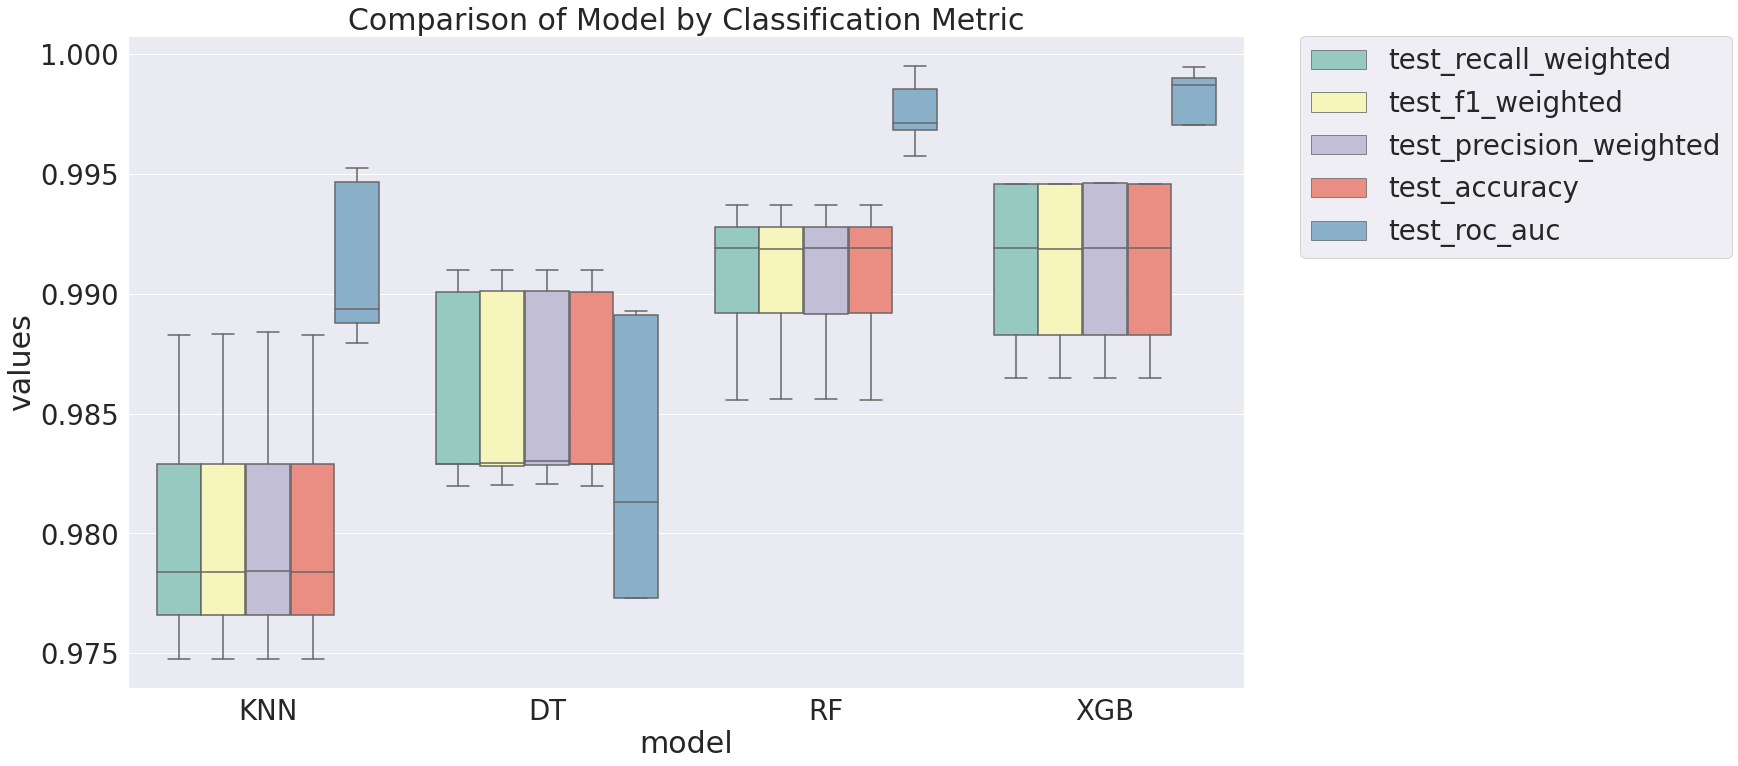

In [38]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Classification Metric')
plt.savefig('./exec-results/eoa/analysis/benchmark_models_performance.png',dpi=300)

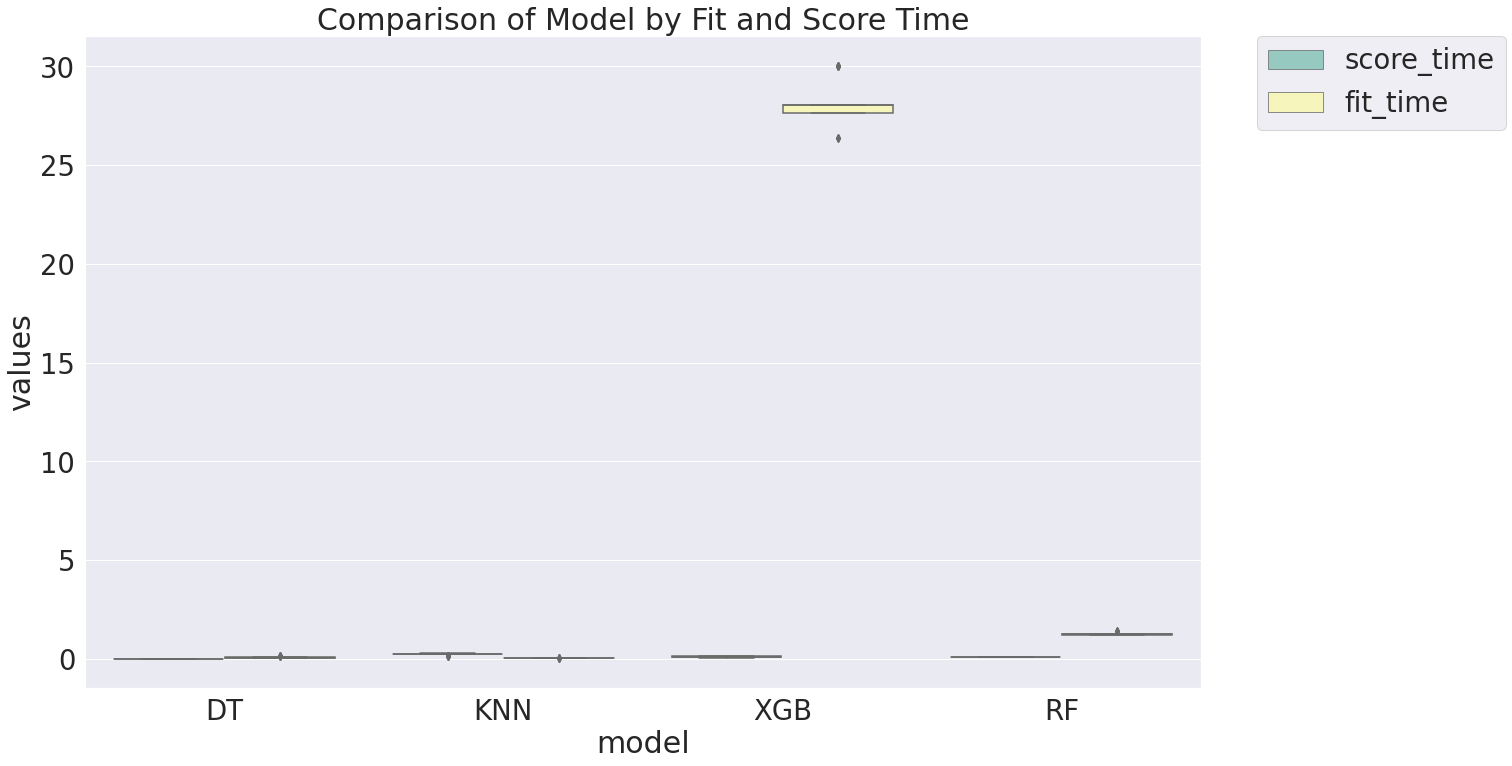

In [39]:
plt.figure(figsize=(20, 12))
sns.set(font_scale=2.5)
g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Set3")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Comparison of Model by Fit and Score Time')
plt.savefig('./exec-results/eoa/analysis/benchmark_models_time.png',dpi=300)

In [40]:
metrics = list(set(results_long_nofit.metrics.values))
bootstrap_df.groupby(['model'])[metrics].agg([np.std, np.mean])

test_f1_weighted           test_recall_weighted            \
                   std      mean                  std      mean   
model                                                             
DT            0.003917  0.985559             0.003913  0.985560   
KNN           0.004649  0.980198             0.004642  0.980186   
RF            0.003050  0.990451             0.003055  0.990452   
XGB           0.003231  0.990992             0.003229  0.990994   

      test_precision_weighted           test_accuracy           test_roc_auc  \
                          std      mean           std      mean          std   
model                                                                          
DT                   0.003895  0.985603      0.003913  0.985560     0.005137   
KNN                  0.004671  0.980221      0.004642  0.980186     0.003190   
RF                   0.003043  0.990457      0.003055  0.990452     0.001292   
XGB                  0.003234  0.991000      0.003229  0.990994     0.000958   

                 
           mean  
model            
DT     0.982838  
KNN    0.991215  
RF     0.997565  
XGB    0.998319

In [41]:
time_metrics = list(set(results_long_fit.metrics.values))
bootstrap_df.groupby(['model'])[time_metrics].agg([np.std, np.mean])

fit_time            score_time          
            std       mean        std      mean
model                                          
DT     0.044207   0.082358   0.001581  0.016357
KNN    0.014714   0.034006   0.036572  0.231104
RF     0.063811   1.261913   0.007084  0.106638
XGB    1.063994  28.183340   0.033780  0.089097